## T Cell Clustering <a class="tocSkip">

Loads integrated T cell anndata and marker gene dictionary, performs Phenograph clustering using various resolutions, and calculates DEGs for each cluster. Saves and zips DEG tables for further analysis, and creates other helpful heatmaps with specific genes.

Author: Kevin Hoffer-Hawlik

## Setup

In [1]:
import warnings
# warnings.simplefilter(action='ignore',)
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=ResourceWarning)

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scvi
import seaborn as sns
import scipy.stats
import scib
import pickle

Global seed set to 0
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
warnings.simplefilter(action='ignore',)

## Load Data

In [6]:
# load marker genes dictionary
marker_genes_filepath = 'marker_genes_dict_030823.pickle'

with open(marker_genes_filepath, 'rb') as handle:
    marker_genes = pickle.load(handle)
marker_genes.keys()

dict_keys(['lineage_markers', 'naive_markers', 'memory_markers', 'exhaustion_markers', 'activation_markers', 'effector_cytokines', 'transcription_factors', 'self-renewal/memory markers', 'NK/gd T cell genes', 'Th17', 'Treg', 'Tfh', 'Th22', 'Th9', 'Pro_inflammatory', 'Cytolytics_effector_pathway', 'CD8_T_cell_activation', 'Type_I_interferon_response', 'Type_II_interferon_response', 'Exhaustion/Terminal_differentiation', 'CD8_deletional_tolerance', 'CD8_TIL_dysfunction', 'G2/M', 'G1/S', 'Glycogen_metabolism', 'Hypoxia/HIF_regulated', 'CD4_T _cell_anergy', 'CD8_peripheral_tolerance', 'Anti-inflammatory', 'TCA_cycle', 'Pentose_phosphate_pathway', 'Senescence', 'Adenosine_pathway', 'Glucose_deprivation', 'T_cell_co-inhibitory_receptors', 'Effector_cell_cytotoxicity', 'Terminal_exhaustion', 'Precursor_exhaustion', 'T_naive', 'T_stem_central_memory', 'T_central_memory', 'T_effector_memory', 'T_terminal_effector'])

In [ ]:
tcells_scvi = sc.read_h5ad("tcells_scvi_umap_030823.h5ad")

## Perform Phenograph Clustering

Finding 330 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 30.701581478118896 seconds
Jaccard graph constructed in 40.49011731147766 seconds
Wrote graph to binary file in 3.3751442432403564 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.587808
After 14 runs, maximum modularity is Q = 0.58904
Louvain completed 34 runs in 87.14895868301392 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 167.03910422325134 seconds
Finding 270 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 27.96305799484253 seconds
Jaccard graph constructed in 31.942617654800415 seconds
Wrote graph to binary file in 2.6090266704559326 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.605997
Louvain completed 21 runs in 45.03702688217163 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 114.64849352836609 seconds
F

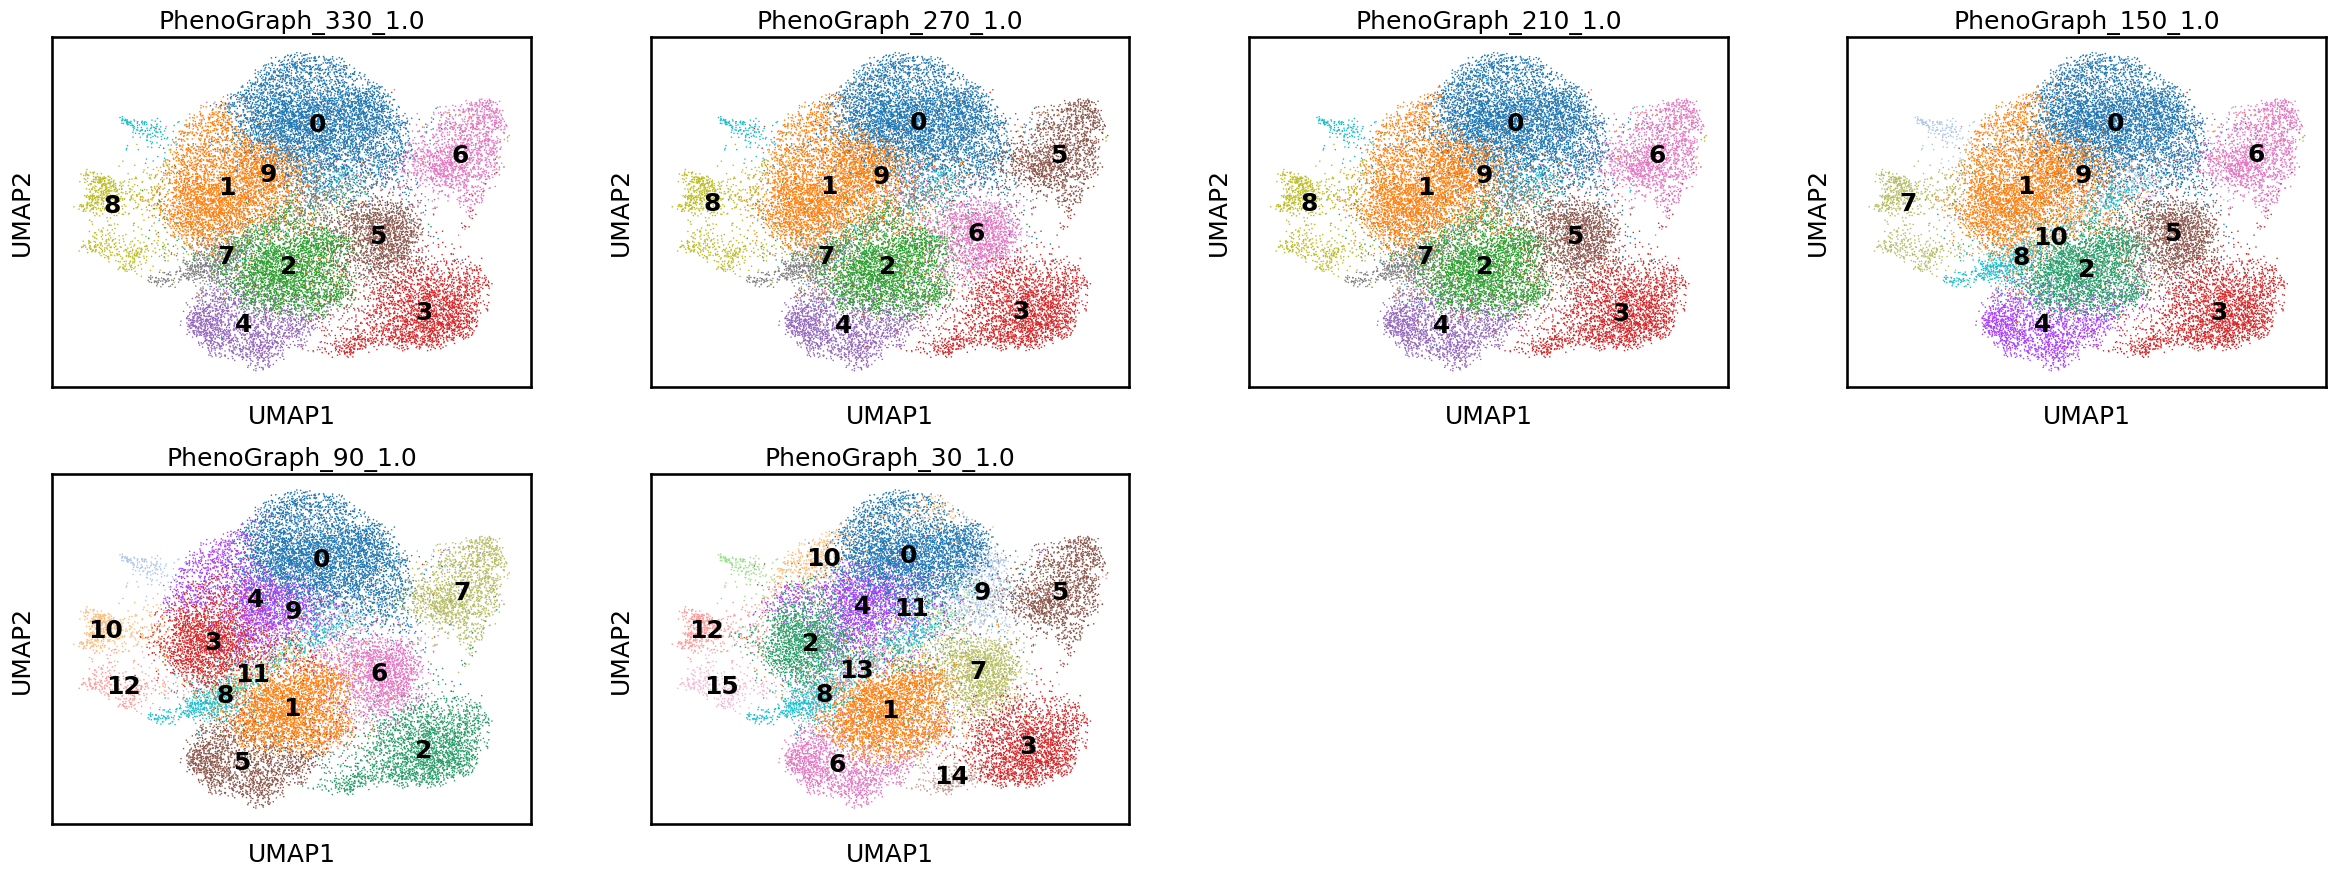

In [8]:
# test different kNN graphs for different resolutions
keys = []
for k in np.arange(330, 29, -60):    
    cluster_key = f"PhenoGraph_{k}_1.0"
    keys.append(cluster_key)
    communities, graph, Q = sc.external.tl.phenograph(tcells_scvi.obsm['X_scVI'], k = k, resolution_parameter = 1)
    tcells_scvi.obs[cluster_key] = pd.Categorical(communities)
    tcells_scvi.uns[cluster_key+'_Q'] = Q

sc.pl.umap(tcells_scvi, color=keys, legend_loc="on data", ncols = 4)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 24.762734413146973 seconds
Jaccard graph constructed in 9.726420402526855 seconds
Wrote graph to binary file in 0.2792541980743408 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.737322
After 3 runs, maximum modularity is Q = 0.740869
After 8 runs, maximum modularity is Q = 0.742379
Louvain completed 28 runs in 14.836606979370117 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 57.283337116241455 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 26.118476152420044 seconds
Jaccard graph constructed in 9.586239337921143 seconds
Wrote graph to binary file in 0.28055596351623535 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.740343
After 4 runs, maximum modularity is Q = 0.742357
After 7 runs, maximum modularity is Q = 0.744035
Louva

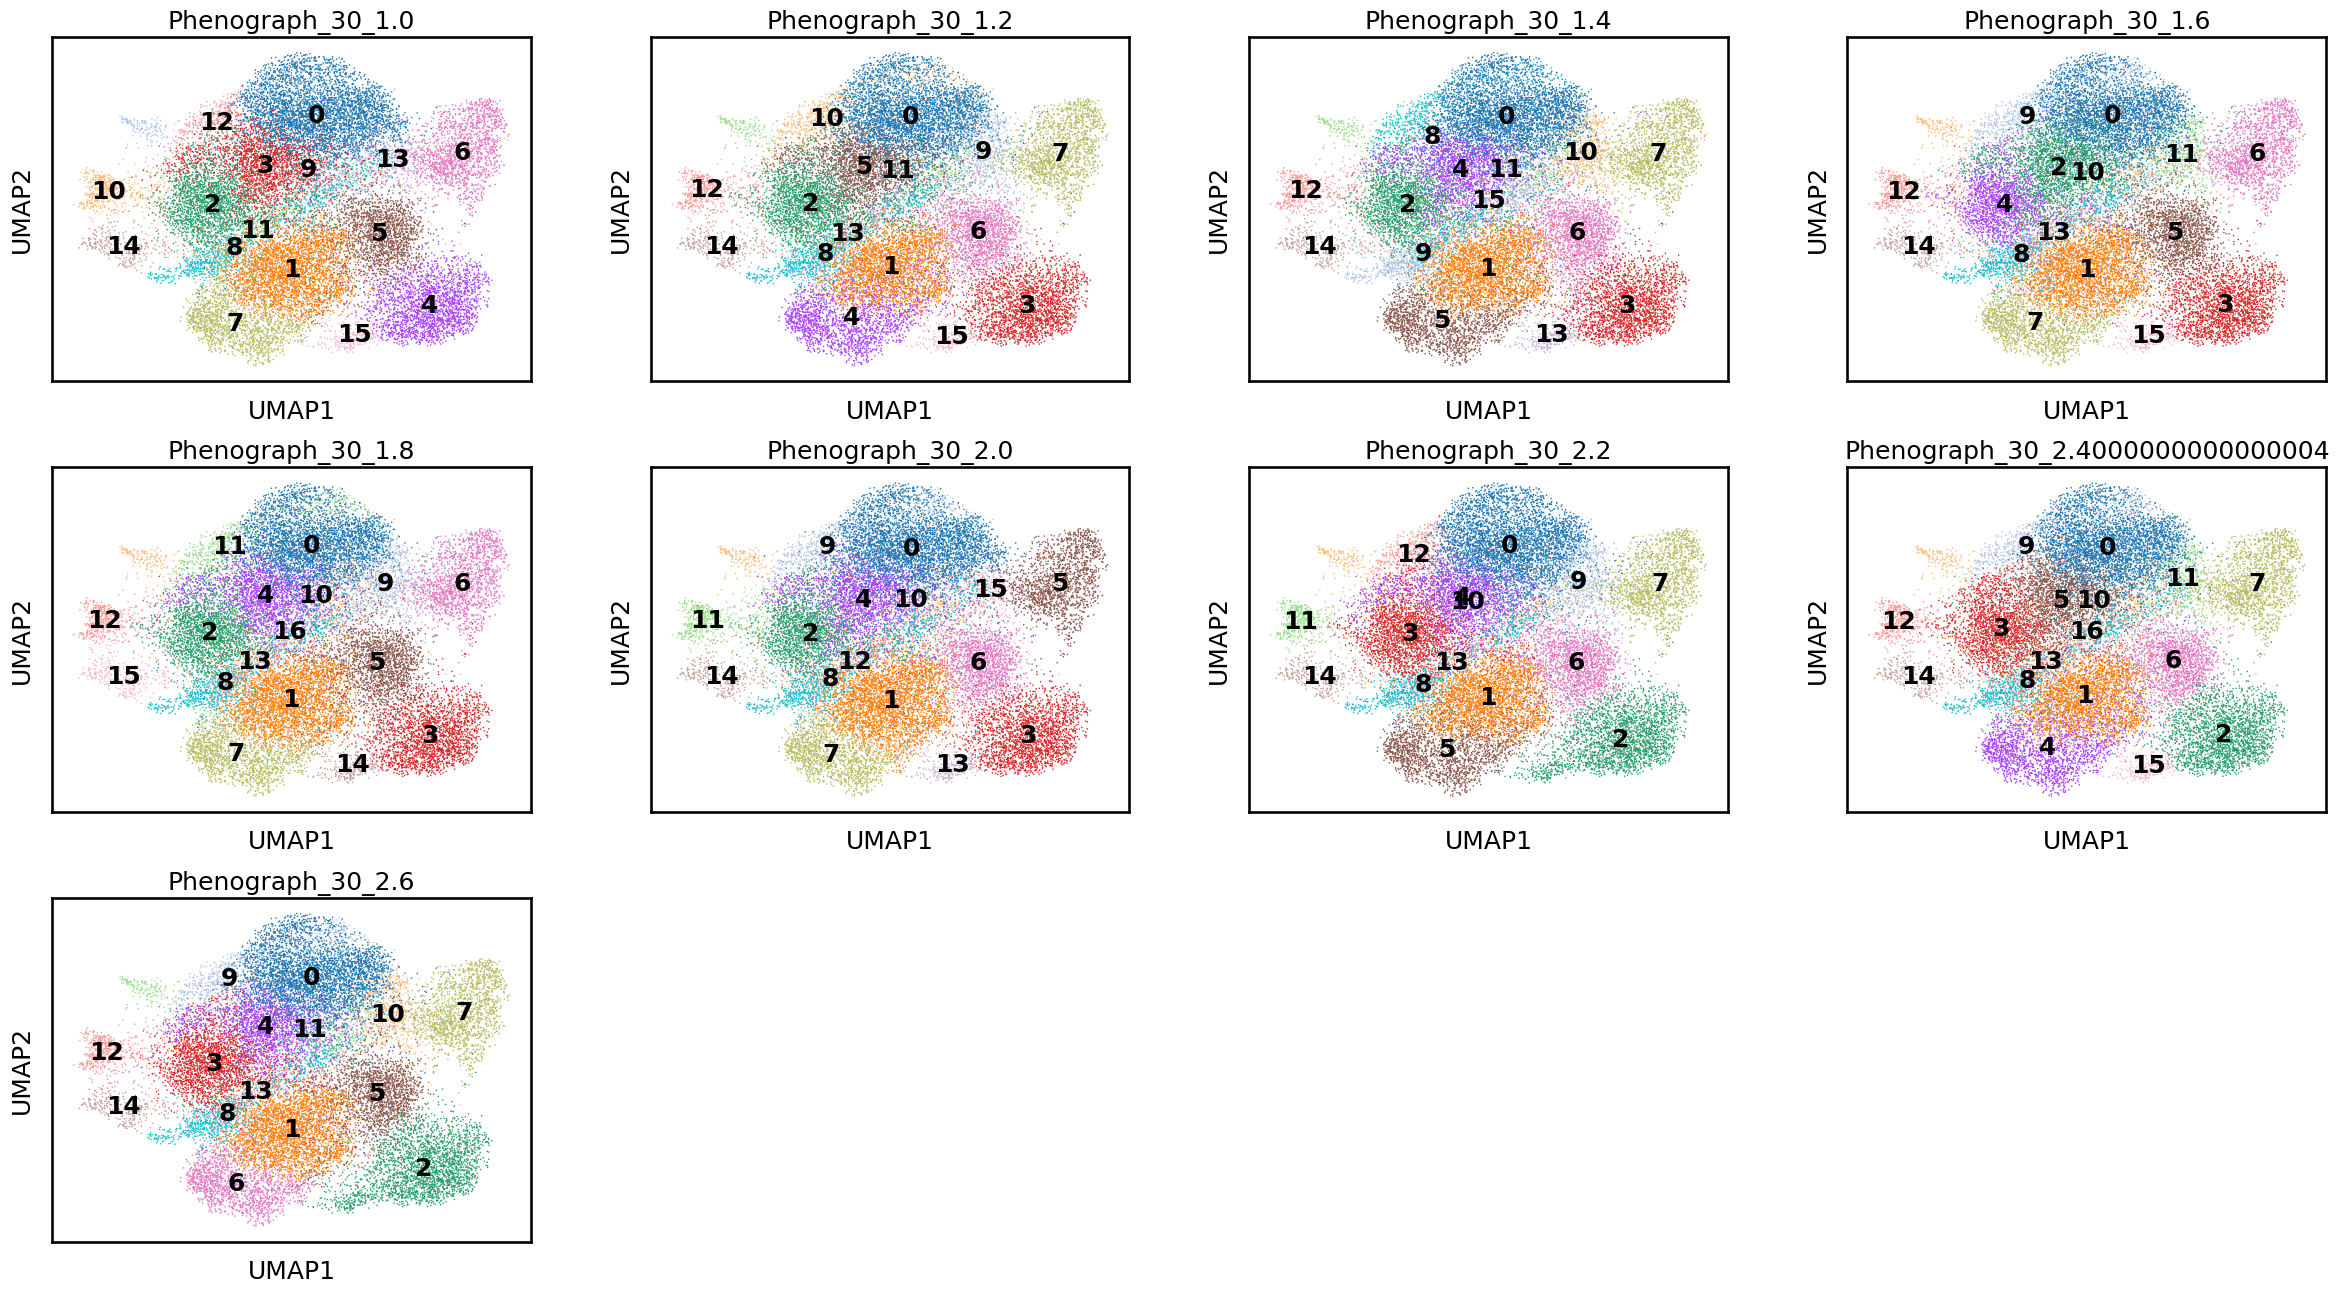

In [10]:
# test different resolution parameters as well
keys = []
for r in np.linspace(1.0, 2.6, 9):
    cluster_key = f"Phenograph_30_{r}"
    keys.append(cluster_key)
    communities, graph, Q = sc.external.tl.phenograph(tcells_scvi.obsm['X_scVI'], k = 30, resolution_parameter = r)
    tcells_scvi.obs[cluster_key] = pd.Categorical(communities)
    tcells_scvi.uns[cluster_key+'_Q'] = Q

sc.pl.umap(tcells_scvi, color=keys, legend_loc="on data", ncols = 4)

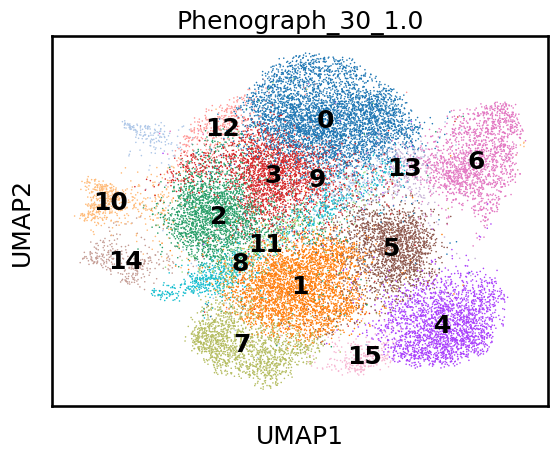

In [11]:
# choose resolution for further analysis
CLUSTERS = 'Phenograph_30_1.0'
sc.pl.umap(tcells_scvi, color=CLUSTERS, legend_loc='on data', )

## DEG Analysis

In [ ]:
tcells_scvi.uns["log1p"]["base"] = None # needed if loading anndata (r/w error in scanpy)

# generate DEG tables using unintegrated, logarithmized counts and scanpy methods
sc.tl.rank_genes_groups(tcells_scvi, 
                        groupby=CLUSTERS,
                        use_raw = True,
                        method='t-test', 
                        key_added = "t-test")
deg_df = sc.get.rank_genes_groups_df(tcells_scvi, group=None, key='t-test').sort_values(["scores"],ascending=False)
deg_df

group   names     scores  logfoldchanges  pvals  pvals_adj
0          0    LYST  80.707214        1.864062    0.0        0.0
1          0     TOX  62.937965        1.562448    0.0        0.0
143164     4   IKZF2  62.242996        3.204288    0.0        0.0
250537     7   BACH2  61.619392        3.831140    0.0        0.0
250538     7    LEF1  61.109005        3.763866    0.0        0.0
...      ...     ...        ...             ...    ...        ...
178951     4  THEMIS -77.929771       -3.017427    0.0        0.0
178952     4   KLRK1 -78.515327       -4.443539    0.0        0.0
35790      0    IL7R -80.805237       -4.282598    0.0        0.0
178953     4    CCL5 -82.311478       -3.874010    0.0        0.0
178954     4    CD8A -87.894203       -4.656825    0.0        0.0

[572656 rows x 6 columns]

## Additional Helpful Plots

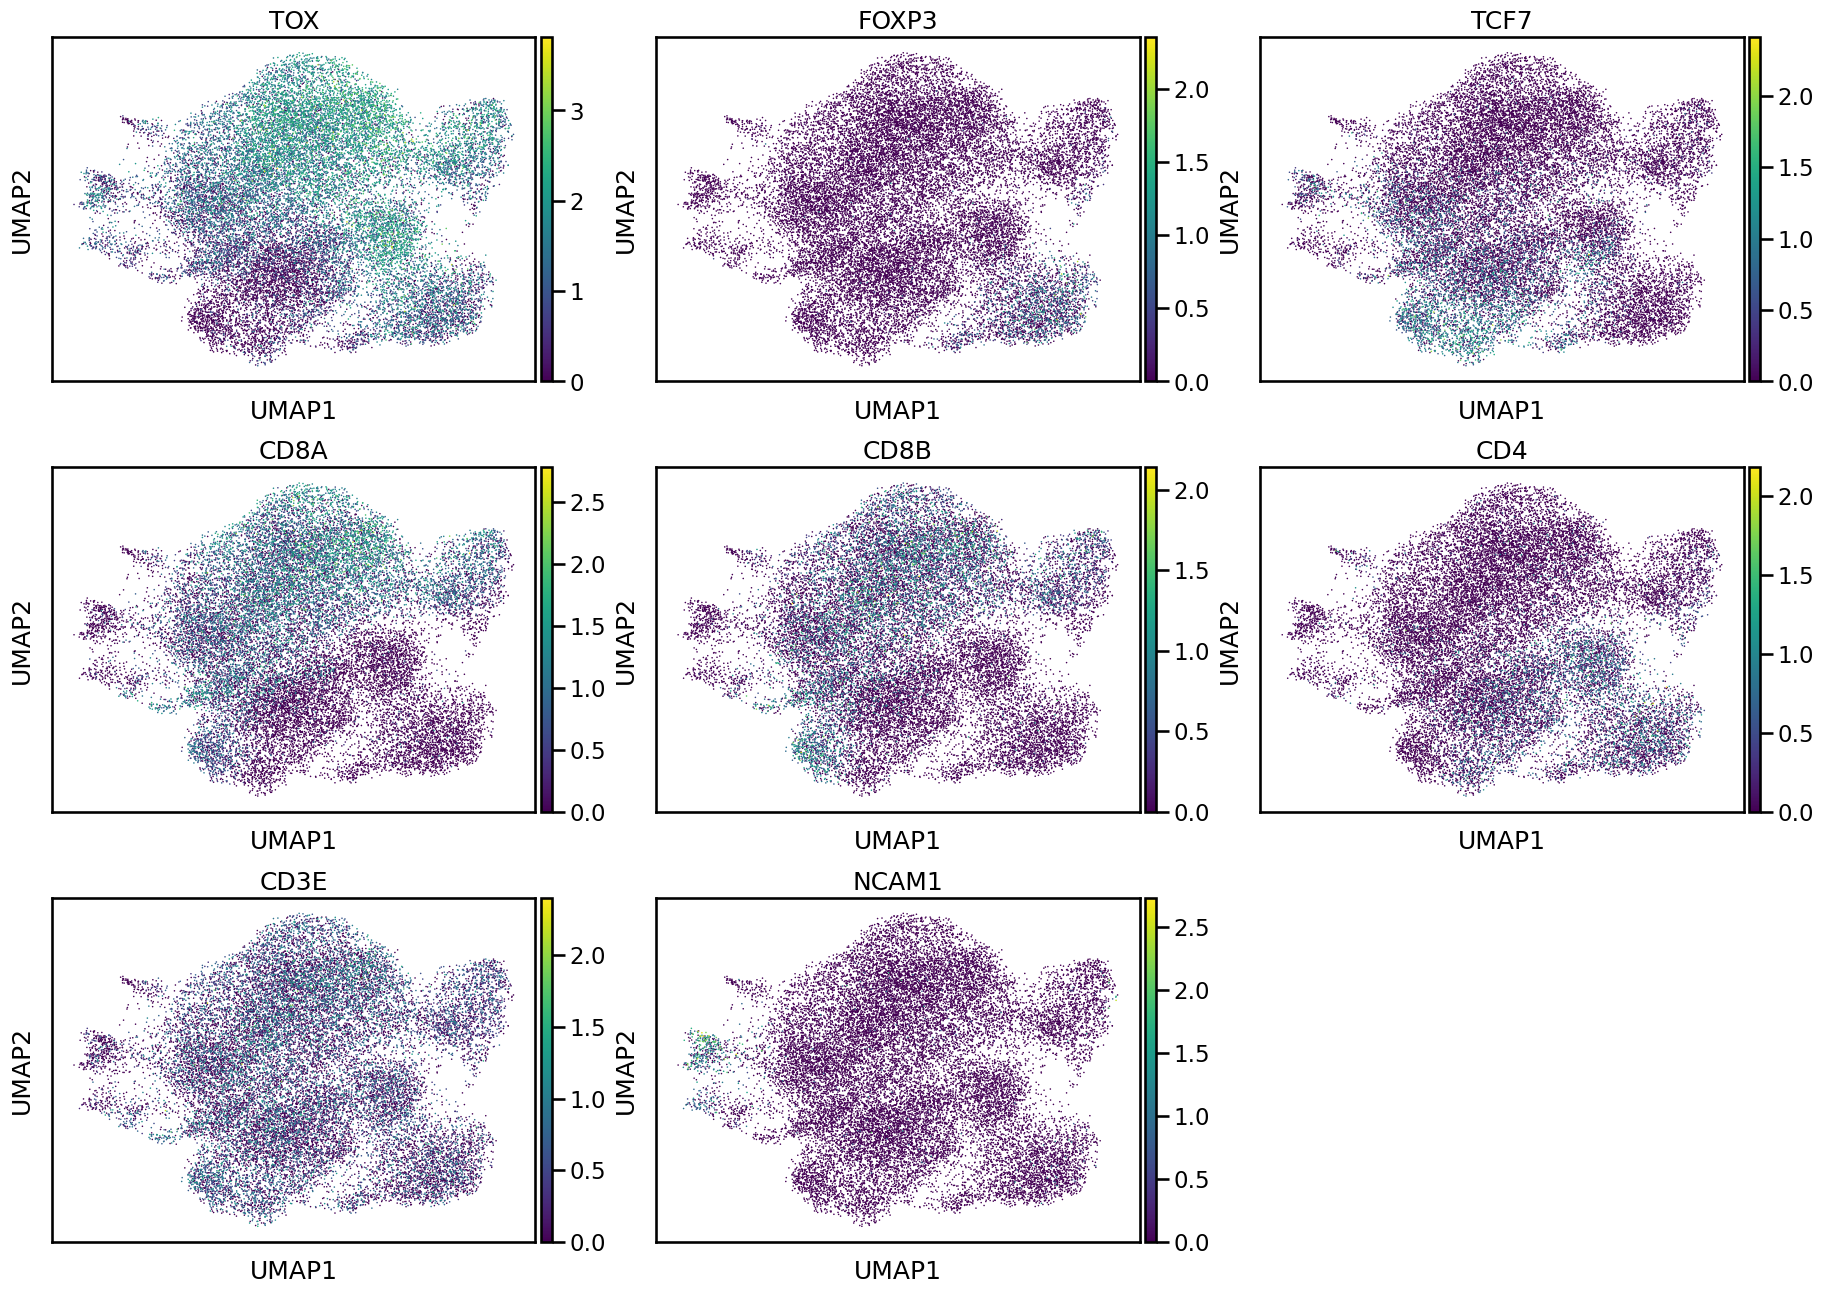

In [15]:
# heat maps of specific genes
hmap_keys = ["TOX", "FOXP3", "TCF7", "CD8A", "CD8B", "CD4", "CD3E", "NCAM1"]
sc.pl.umap(tcells_scvi,color=hmap_keys, ncols=3)

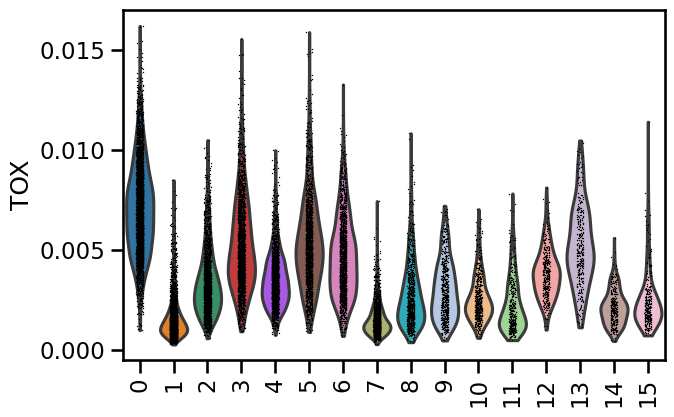

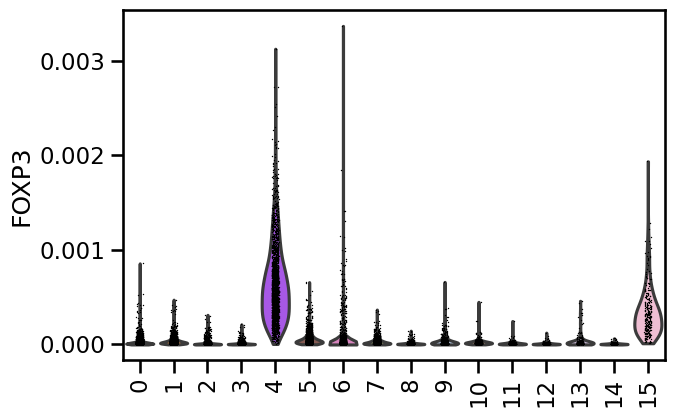

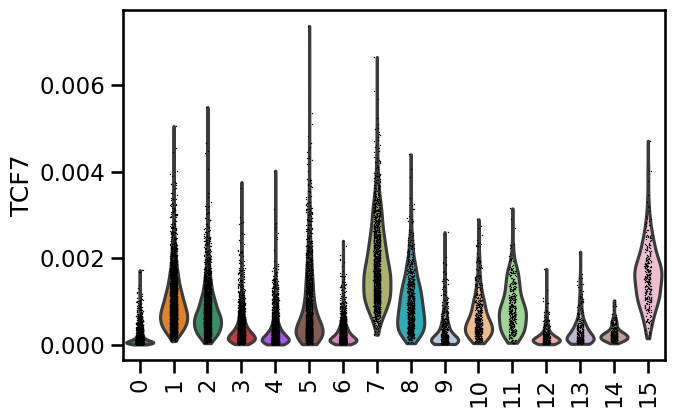

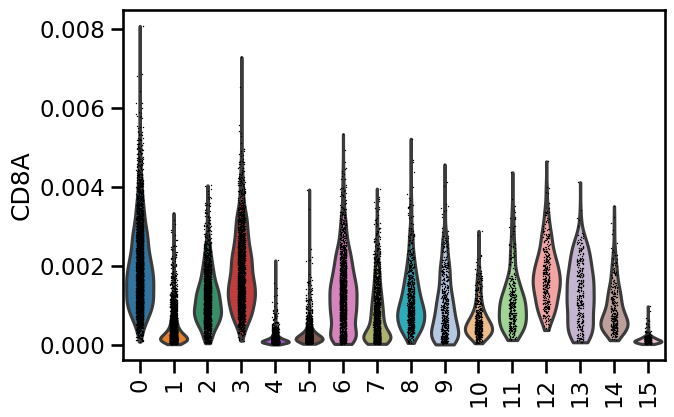

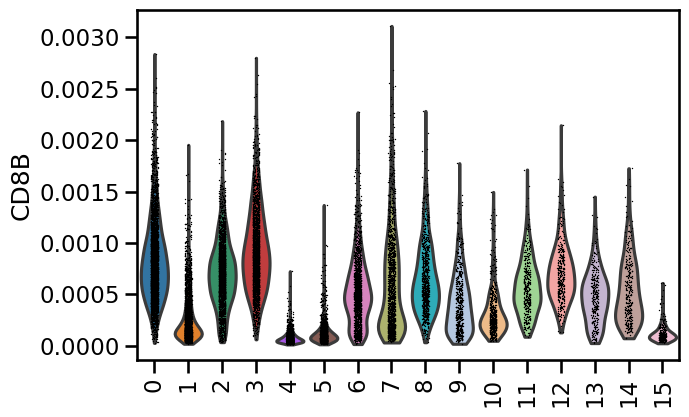

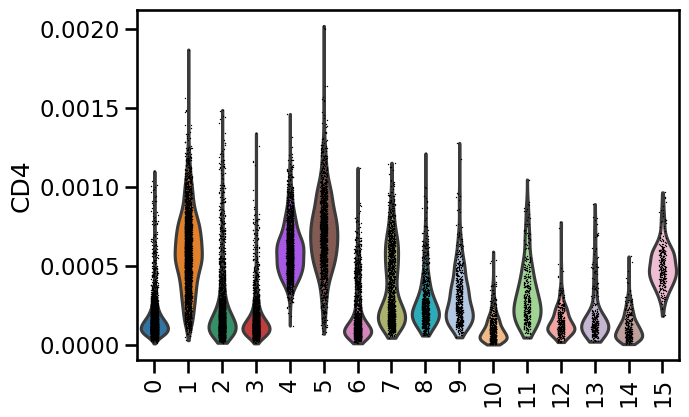

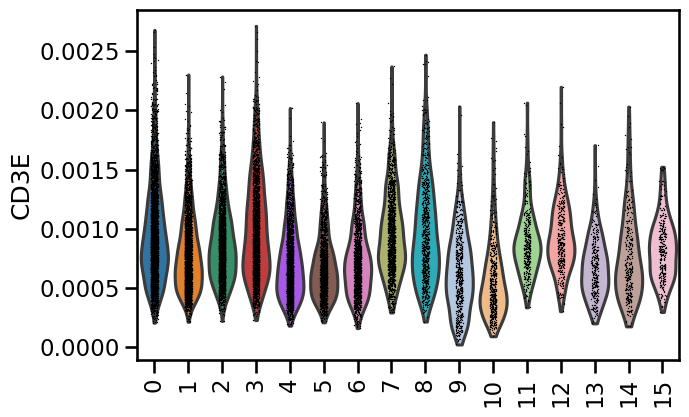

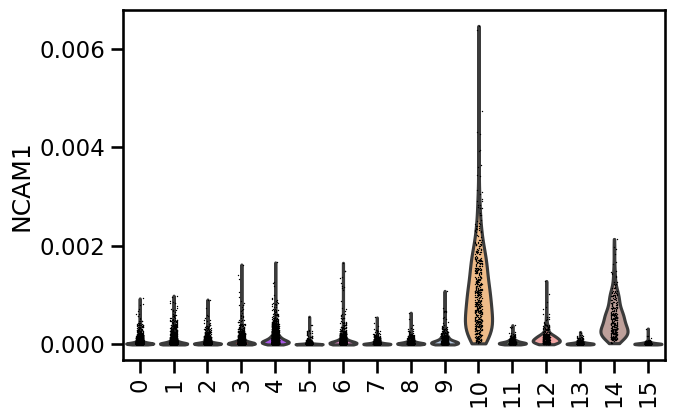

In [16]:
    # violin plots of specific genes
    violin_keys = ["TOX", "FOXP3", "TCF7", "CD8A", "CD8B", "CD4", "CD3E", "NCAM1"]
    for key in violin_keys:
        sc.pl.violin(tcells_scvi, layer = "scvi_normalized", use_raw = False, keys=key, groupby=CLUSTERS, rotation=90)

## Save and Export Files

In [17]:
# save file
tcells_scvi.write("tcells_scvi_clusters_030823.h5ad") #, compression="gzip") # save scVI output anndata file

In [18]:
# export deg_df for each group
for group in np.unique(tcells_scvi.obs[CLUSTERS]):
    deg = deg_df.loc[deg_df.group==str(group),:]
    deg.to_csv("deg_tables/DEG_group" + str(group) + "_030823.csv")